Now that the clean data set has been obtained, models will be trained and tested for accuracy. The first step is to import the necessary modules and packes for our analysis.

In [201]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn import svm
from sklearn.preprocessing import scale
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
data = pd.read_csv('Data/clean_data.csv')

Since the clean data contains an unnecessary column named "Unnamed: 0", it has been excluded. Moreover, Loan_ID has absolutely no impact on the loan approvals and hence it will also be excluded from analysis.

In [4]:
data = data.drop(['Unnamed: 0', 'Loan_ID'], axis=1)

In [5]:
data.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,146.412162,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,Y


In the next step, variables in the model that are categorical features will be identified

In [6]:
df_cats = data[['Gender', 'Married', 'Dependents', 'Self_Employed', 'Education', 'Property_Area']]

We now apply the get_dummies method to create dummy variables for each categorical variable. For example, for the variable "Married" will be split into two columns : "Married_Yes" and "Married_No". The "Yes" and "No" are the values assigned to the original column. The Married_Yes column will have 1s for those are married and 0s for those who aren't. The Married_No column will have 1s for those who are not married and a 0 for those who are married. Hence, we know that a person can have a 1 assigned to either "Married_Yes" or "Married_No" but not both. Hence, this is redunant information and one of the dummy variable columns needs to be excluded from analysis. This can be achieved by specifying the parameter "drop_first" set to True which drops one dummy column for each categorical variable.

In [7]:
df_cats_dummies = pd.get_dummies(df_cats, drop_first=True)

The other variables for analysis have been identified and assigned to a dataframe.

In [9]:
df_other_vars = data[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']]

The dataframs containing the categorical features (now with dummy variables) and the non categorical features have been concatenated column wise.

In [11]:
X_set = pd.concat([df_cats_dummies, df_other_vars], axis=1)

The dummy variables can be observed below.

In [12]:
X_set.head()

,Gender_Male,Gender_Other,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Self_Employed_Yes,Education_Not Graduate,Property_Area_Semiurban,Property_Area_Urban,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
0,1,0,0,0,0,0,0,0,0,1,5849,0.0,146.412162,360.0,1.0
1,1,0,1,1,0,0,0,0,0,0,4583,1508.0,128.000000,360.0,1.0
2,1,0,1,0,0,0,1,0,0,1,3000,0.0,66.000000,360.0,1.0
3,1,0,1,0,0,0,0,1,0,1,2583,2358.0,120.000000,360.0,1.0
4,1,0,0,0,0,0,0,0,0,1,6000,0.0,141.000000,360.0,1.0


In [13]:
X = X_set.values

The dependent variable, "y" will have a value of 1 assigned if the loan has been approved and a 0 for those who didn't have their loans approved.

In [14]:
y = (data.Loan_Status == 'Y')

In [15]:
y = y.values

The raw data will now be split into the into the tes and training sets

# Random Forest Classifier 

**Why Random Forests over decision trees?**

**Decision tress train over a single training set only. Decision trees take into account each and every variable and every observation in the training set. While decision trees are very fast (in terms of computational speed), they generally overfit the data and perform poorly on test sets.**

**To solve this, we could generate bootstrap samples. That is, we generate samples with replacement. We now have multiple samples instead of one training sample. But these training samples are bound to have duplicate observations. While this model does perform better, it does have access to all the features and most of the observations. To enhance the randomness, each sampleis trained with a unique set of features. If we have "n" number of features, the algorithm used  sqrt(n) features for each model. What results is a series of "weak models". These weak models are then "aggregated" to give a strong prediction model. Hence, the randomness comes from the bootstrap samples generated and the features involved for predicting each sample.**

**Since this is an ensemble approach which combines the best of different approaches, we will try the Random Forest classifier to predict our model with the hope of achieveing "large initial gains".**

**The primary assumptions for this algorithm is that the randomly generated bootstrap samples with each sample set using a dictict set of features are independent of each other.**

In [104]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=42, test_size=0.25)

In [108]:
clf_rf = RandomForestClassifier(random_state=42)

The classifier will now be fit on the training data

In [18]:
clf_rf.fit(Xtrain, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

The model will now be used to predict the test set.

In [19]:
y_pred_rf = clf_rf.predict(Xtest)

Cross validation is performed to ensure independence from one single split of the data into test and training models.

In [21]:
cv_scores = cross_val_score(clf_rf, Xtrain, ytrain, cv = 5)
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

Average 5-Fold CV Score: 0.6937818843148437


In [20]:
cv_scores = cross_val_score(clf_rf, Xtrain, ytrain, cv = 5, scoring = 'roc_auc')
print("Average 5-Fold CV Score using ROC scoring: {}".format(np.mean(cv_scores)))

Average 5-Fold CV Score using ROC scoring: 0.6948292824074074


In [23]:
accuracy_score(ytest, y_pred_rf)

0.6948051948051948

The average accuracy on the test set was a mere 69%.

In [116]:
n_space = np.array([5, 6, 10, 12, 15, 50])
param_grid = {'n_estimators': n_space}

In [117]:
rf_clf_tuning = GridSearchCV(clf_rf, param_grid, cv=5)

In [118]:
rf_clf_tuning.fit(Xtrain, ytrain)

C:\Users\Aditya\Miniconda2\envs\ipykernel_py3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': array([ 5,  6, 10, 12, 15, 50])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [119]:
print("Tuned RF Parameters: {}".format(rf_clf_tuning.best_params_)) 
print("Best score is {}".format(rf_clf_tuning.best_score_))

Tuned RF Parameters: {'n_estimators': 50}
Best score is 0.7326086956521739


In [150]:
best_rf_clf = RandomForestClassifier(n_estimators = 50, random_state=42)

In [151]:
best_rf_clf.fit(Xtrain, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [152]:
y_best_rf_preds = best_rf_clf.predict(Xtest)

In [153]:
accuracy_score(ytest, y_best_rf_preds)

0.7272727272727273

In [154]:
y_best_rf_probas = best_rf_clf.predict_proba(Xtest)[:,1]

In [167]:
print(classification_report(ytest, (y_best_rf_probas > 0.5).astype(int)))

              precision    recall  f1-score   support

       False       0.69      0.41      0.51        54
        True       0.74      0.90      0.81       100

   micro avg       0.73      0.73      0.73       154
   macro avg       0.71      0.65      0.66       154
weighted avg       0.72      0.73      0.71       154



As we have used the Random Forest classifier method, the feature importance of variables will be plotted which will help better understand which variables are crucial for analysis and which aren't.

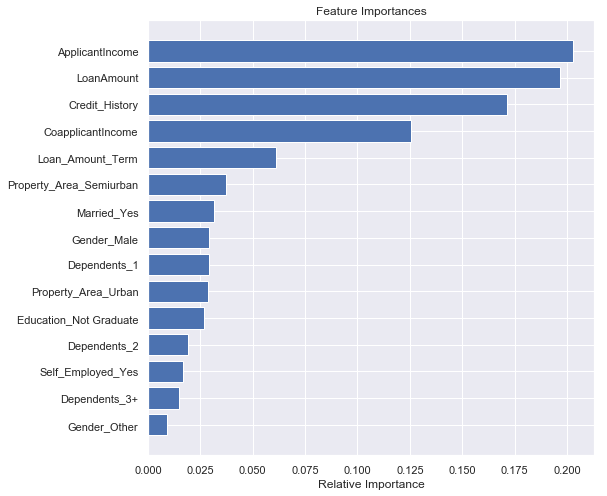

In [200]:
fig, ax = plt.subplots(figsize=(8,8))
features = X_set.columns
importances = best_rf_clf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

From the above plot, it can be observed that the categorical variables Gender(Gender_Male, Gender_Other), Dependents(Dependents_1, Dependents_1, Dependents_3+), Married(Married_Yes) and Self_Employed(Self_Employed_Yes) have relatively low variance.

In [24]:
y_rf_probs = clf_rf.predict_proba(Xtest)

We will compute the precision recall curve and roc curve. For both curves, greater areas under the curves are indicative of better models.

In [187]:
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(ytest, y_best_rf_probas)

In [169]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(ytest, y_best_rf_probas)

# Support Vector Machines

**How do they work?**

**SVMs are used to predict non-linear models. It is a supervised learning algorithm and a non-probabilistic classifier. Given a training set, the SVM algorithm separates the data points into various labelled classes using the __[kernel trick](https://en.wikipedia.org/wiki/Kernel_method)__ . The kernel trick is used to map points in the high dimensional space essentially builiding the non-linear classification boundary. SVMs perform better than linear models since most real world data is non-linear in nature.**


Next, the model will be analyzed using Support Vector Machines. Before beginnign analysis, all the values for the variables must be on the same scale. This will help us better our analysis.

The variables are scaled using the "scale" method.

In [27]:
X_scaled = scale(X_set)

C:\Users\Aditya\Miniconda2\envs\ipykernel_py3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by the scale function.
  """Entry point for launching an IPython kernel.


We initialize the classifier object.

In [31]:
svm_clf = svm.SVC(kernel='rbf', gamma = 'auto')

In [32]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_scaled, y, random_state=42, test_size=0.25)

The SVM classifier will now be used to train the data.

In [33]:
svm_clf.fit(Xtrain, ytrain)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [34]:
cv_scores = cross_val_score(svm_clf, Xtrain, ytrain, cv = 5)
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

Average 5-Fold CV Score: 0.7435730468689796


The average accuracy on the training set has been computed at ~74%.

We will now predict on the test set.

In [35]:
y_pred = svm_clf.predict(Xtest)

In [36]:
accuracy_score(ytest, y_pred)

0.7532467532467533

The test set accuracy is approximately ~75% which is close to training set accuracy. This is decent model as it has a success rate of 3 over 4.

We now perform hyper parameter tuning to see if we can achieve a higher accuracy score.

In [37]:
C_space = np.array([0.001, 0.1, 1])
param_grid = {'C': C_space}

In [38]:
svm_clf_tuning = GridSearchCV(svm_clf, param_grid, cv=5)

In [39]:
svm_clf_tuning.fit(Xtrain, ytrain)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([0.001, 0.1  , 1.   ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [40]:
print("Tuned SVM Parameters: {}".format(svm_clf_tuning.best_params_)) 
print("Best score is {}".format(svm_clf_tuning.best_score_))

Tuned SVM Parameters: {'C': 1.0}
Best score is 0.7434782608695653


By training the model and testing on the training set, we achieved an accuracy score of ~74%.

**We cannot directly use the predict_proba function with SVM classifiers. It will throw an error. Hence, we use SVM classifiers with CalibratedClassifierCV which will allow us to use the predict_proba method whic is crucial for plotting Precision_recall curves and ROC curves. These curves help evaluate how good our model is.**

**The class CalibratedClassifierCV uses a cross-validation generator and estimates for each split the model parameter on the train samples and the calibration of the test samples. The probabilities predicted for the folds are then averaged.** 

**The major drawback is that the accuracy and other performance parameters will will not perform as well as the original model (in our case, the SVM Classifier). However, it's performance will be very close to the original model which will help us evaluate the performance of SVM classifier.**

In [41]:
from sklearn.calibration import CalibratedClassifierCV
svm_clf = svm.SVC(gamma = 'auto')
clf2 = CalibratedClassifierCV(svm_clf) #As discussed above, the CalibratedClassifierCV class will be used with our classifier.
clf2.fit(Xtrain, ytrain)

CalibratedClassifierCV(base_estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
            cv='warn', method='sigmoid')

In [43]:
y_svm_pr = clf2.predict(Xtest)

In [44]:
accuracy_score(ytest, y_svm_pr)

0.7532467532467533

In [45]:
print(classification_report(ytest, y_svm_pr))

              precision    recall  f1-score   support

       False       0.77      0.43      0.55        54
        True       0.75      0.93      0.83       100

   micro avg       0.75      0.75      0.75       154
   macro avg       0.76      0.68      0.69       154
weighted avg       0.76      0.75      0.73       154



In [46]:
y_svm_preds = clf2.predict_proba(Xtest)

We will compute the precion_recall curves and the ROC curves.

In [98]:
precision_sv, recall_sv, thresholds_sv = precision_recall_curve(ytest, y_svm_preds[:, 1])

In [48]:
fpr_sv, tpr_sv, thresholds_sv = roc_curve(ytest, y_svm_preds[:, 1])

Next, we will consider the Logistic regression approach.

 # Logistic Regression 

**This a traditional and basic approach to classification in supervised learning. It derives its name since it uses the __[logit function](https://en.wikipedia.org/wiki/Logit)__**.

**The logisic regression model is performed with some assumptions : that data has no outliers, there are two classes to be predicted, and that no two independent variables are highly correlated to each other.**

In [144]:
clf_log = LogisticRegression()

In most data sets, we will have features with highly varying magnitudes, units and range. Features with greater magnitudes will carry a greater weight than those with low magnitudes. To nullify this effect, feature scaling is performed.

In [145]:
X_set_scale = scale(X_set)

C:\Users\Aditya\Miniconda2\envs\ipykernel_py3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by the scale function.
  """Entry point for launching an IPython kernel.


In [224]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_set_scale, y, random_state=42, test_size=0.25)

In [147]:
clf_log.fit(Xtrain, ytrain)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [148]:
y_log_pred = clf_log.predict(Xtest)

In [149]:
accuracy_score(ytest, y_log_pred)

0.7337662337662337

We achieved an accuracy of ~73% which is decent. Let us now try hyper parameter tuning to see of we can better this score.

In [59]:
C_space = np.array([0.0001, 0.001, 0.1, 1])

In [60]:
param_grid = {'C': C_space}

In [61]:
clf_log_tuning = GridSearchCV(clf_log, param_grid, cv=5)

In [62]:
clf_log_tuning.fit(Xtrain, ytrain)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([1.e-04, 1.e-03, 1.e-01, 1.e+00])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [63]:
print("Tuned Logistic Regression Parameters: {}".format(clf_log_tuning .best_params_)) 
print("Best score is {}".format(clf_log_tuning .best_score_))

Tuned Logistic Regression Parameters: {'C': 0.0001}
Best score is 0.75


Using Logistic Regression, we achieved a training set accuracy of ~75% (in terms of training set accuracy alone.)

Next, the model will be fit with the best parameter of C and then it will be used to predict the test set.

In [64]:
clf_log = LogisticRegression(C = 0.0001)

In [65]:
clf_log.fit(Xtrain, ytrain)

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [66]:
y_preds = clf_log.predict(Xtest)

In [67]:
p_clf_log_ba = clf_log.predict_proba(Xtest)

In [68]:
accuracy_score(ytest, y_preds)

0.7532467532467533

The accuracy score is close to ~75% which is really close to the training set accuracy. The Logistic Regression model performed best.

In [69]:
print(classification_report(ytest, y_preds))

              precision    recall  f1-score   support

       False       0.77      0.43      0.55        54
        True       0.75      0.93      0.83       100

   micro avg       0.75      0.75      0.75       154
   macro avg       0.76      0.68      0.69       154
weighted avg       0.76      0.75      0.73       154



Next, we will compute the ROC curve and the precision_recall curve.

In [70]:
precision_lg, recall_lg, thresholds_lg = precision_recall_curve(ytest, p_clf_log_ba[:, 1])

In [71]:
fpr_lg, tpr_lg, thresholds_lg = roc_curve(ytest, p_clf_log_ba[:, 1])

# Precision_Recall and ROC curves

The Precision_Recall curves will be plotted for each of the classifiers to determine the best fit.

Text(0.5, 1.0, 'Precision vs. Recall curve')

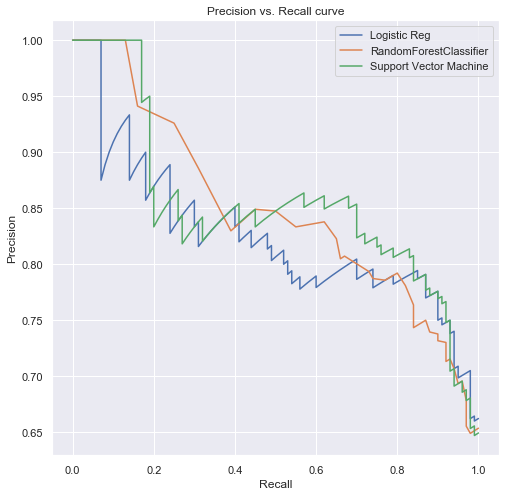

In [272]:
fig, ax = plt.subplots(figsize=(8,8))
plt.plot(recall_lg, precision_lg)
plt.plot(recall_rf, precision_rf)
plt.plot(recall_sv, precision_sv)
plt.legend(('Logistic Reg', 'RandomForestClassifier', 'Support Vector Machine'))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs. Recall curve')

**From the above plot, Support Vector Machines seem to be performing better than the other two classifiers. We can make this inference as the area under the curves seems to be greaters for SVM.**

In [242]:
area_log_reg = auc(recall_lg, precision_lg)
area_rf = auc(recall_rf, precision_rf)
area_svm = auc(recall_sv, precision_sv)

In [274]:
list1 = ['Logistic Regression Area', 'RandomForestClassifier Area', 'Support Vector Machine']

In [275]:
areas_prec_recall = pd.DataFrame({'Classifiers' : list1, 'Areas' : [area_log_reg, area_rf , area_svm]})

In [276]:
areas_df = areas_prec_recall.sort_values('Areas', ascending = False).set_index('Classifiers')

In [277]:
areas_df

,Areas
Classifiers,
Support Vector Machine,0.852386
RandomForestClassifier Area,0.848723
Logistic Regression Area,0.824748


The area under the Precision_Recall curves have been calculated to confirm our inference that SVM performed better.

**Next, we will plot the ROC curves for each of the classifiers.**

Text(0.5, 1.0, 'ROC Curves')

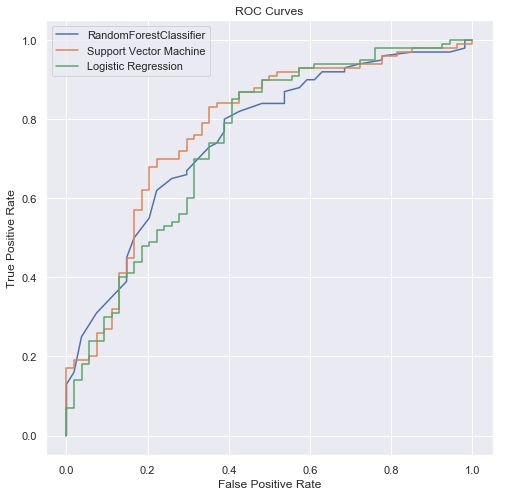

In [278]:
fig, ax = plt.subplots(figsize=(8,8))
plt.plot(fpr_rf, tpr_rf)
plt.plot(fpr_sv, tpr_sv)
plt.plot(fpr_lg, tpr_lg)
plt.legend(('RandomForestClassifier', 'Support Vector Machine', 'Logistic Regression'))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')

**Once again, SVM seems to be peforming better than the other two classifiers.**

In [279]:
list1 = ['Logistic Regression Area', 'RandomForestClassifier Area', 'Support Vector Machine']

In [280]:
areas_roc_df = pd.DataFrame({'Classifiers': list1, 'Areas_ROC': [roc_auc_score(ytest, p_clf_log_ba[:, 1]), roc_auc_score(ytest, y_best_rf_probas),roc_auc_score(ytest, y_svm_preds[:, 1])]})

In [281]:
areas_roc_df = areas_roc_df.sort_values('Areas_ROC', ascending = False).set_index('Classifiers')

In [282]:
areas_roc_df

,Areas_ROC
Classifiers,
Support Vector Machine,0.777222
RandomForestClassifier Area,0.755463
Logistic Regression Area,0.746296


**Once again, the areas were calculated to confirm the inferece that SVM was indeed the best performing model.**

# Prediction using best classifier and with reduced features

**Next, we will try to reduce the dimensions of the data set and fit the model using our best classifier and then predict on the test set to see if we have improved results.**

In [83]:
X_set_new = X_set[['Property_Area_Semiurban','Property_Area_Urban', 'Education_Not Graduate','ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']]

In [84]:
X_set_new_scale = scale(X_set_new)

C:\Users\Aditya\Miniconda2\envs\ipykernel_py3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by the scale function.
  """Entry point for launching an IPython kernel.


In [85]:
svm_new_clf = CalibratedClassifierCV(svm.SVC(gamma = 'auto'))

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X_set_new_scale, y, random_state=42, test_size=0.25)

In [90]:
svm_new_clf.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
            cv='warn', method='sigmoid')

In [91]:
y_pred_svm_new = svm_new_clf.predict(X_test)

In [92]:
accuracy_score(y_test, y_pred_svm_new)

0.7597402597402597

**Using our best classifier and reduced features, the model performed with ~76% accuracy which is close to the previous model with all the features.**

In [93]:
y_pred_new_clf = svm_new_clf.predict_proba(X_test)[:,1]

In [94]:
roc_auc_score(y_test, y_pred_new_clf)

0.7505555555555555

**The areas under the ROC curve is 0.75 which is slightly less than the original value (from the original feature set) of 0.77.**

In [95]:
precision_best, recall_best, thresholds_best = precision_recall_curve(y_test, y_pred_new_clf )

In [96]:
auc(recall_best, precision_best)

0.8043127107294217

**The area under the Precision_recall curve is 0.80 which is less than the originally computed value of 0.85.**

In [97]:
print(classification_report(y_test, y_pred_svm_new))

              precision    recall  f1-score   support

       False       0.74      0.48      0.58        54
        True       0.76      0.91      0.83       100

   micro avg       0.76      0.76      0.76       154
   macro avg       0.75      0.70      0.71       154
weighted avg       0.76      0.76      0.74       154

